# ResNet18 and SEResNet18

In this section of Lab03, ResNet model was implemented on the CIFAR-10 dataset. With the same data set, 2 versions of ResNet were employed namely,

1. ResNet18
2. ResNet18 with Squeeze and Excitation (SEResNet18)

Since the given architechture of ResNet was not the same as what can be found on the original paper, the modification of the architechture was necessary. The modification includes:

e.g.
* The input image size
* The modification of the first convolutional layer
* The addition of a maxpool
* The padding
* The kernal size

The two versions were impleneted with the exact same optimizer as well as the loss functions and they are as follows:

* criterion = nn.CrossEntropyLoss()
* optimizer = optim.Adam(model.parameters(), lr=0.01)

The number of trainable parameters of each model are as follows:

1. ResNet18 has 11,181,642 trainable parameters
2. SEResNet18 has 11,268,682 trainable parameters

The models were both trained for 25 epochs with the batch size of 16 and their performace at the 25th epoch are:

* ResNet18: Train acc = 97.48% , Val acc = 89.20% , Test acc = 85.37% %
* SEResNet18: Train acc = 87.26% , Val acc = 84.63% , Test acc = 84.27% %

The average times taken per epoch are

* ResNet18: 1m 28s
* SEResNet18: 1m 30s


#### Libaries

In [32]:
# Import libraries
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import numpy as np
from torchvision.transforms.transforms import RandomCrop

### 1. Prepare data set

In [33]:
## Resize to 256
### AUGMENT for train
train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

## Resize to 224
### No AUGMENT for test
eval_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=eval_preprocess)


# Prepare the data loaders
BATCH_SIZE=4
NUM_WORKERS=2

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

Files already downloaded and verified
Files already downloaded and verified


### 2. Define model

Since I did not change anything in the class BottleneckBlock, class BasicBlock as well as the function ResNet18, I omit them from this report

In [34]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()

        self.is_debug = False

        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3, stride = 2, padding = 1)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.is_debug : print(f'conv1: {out.shape}')
        out = self.maxpool(out)
        if self.is_debug : print(f'max pool: {out.shape}')
        out = self.layer1(out)
        if self.is_debug : print(f'conv2_x: {out.shape}')
        out = self.layer2(out)
        if self.is_debug : print(f'conv3_x: {out.shape}')
        out = self.layer3(out)
        if self.is_debug : print(f'conv4_x: {out.shape}')
        out = self.layer4(out)
        if self.is_debug : print(f'conv5_x: {out.shape}')
        out = self.avgpool(out)
        if self.is_debug : print(f'avg pool: {out.shape}')
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### 3. Define function for evaluation

In [35]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
                
            loss = criterion(predictions, labels.long())
            
            predictions = nn.functional.softmax(predictions, dim=1)            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
                       
            predicteds.append(predicted)
            trues.append(labels)            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

### 4. Results

#### 4.1 ResNet18 

In [1]:
results_resnet18 = open("output.txt", "r")
print(results_resnet18.read())


====================== ResNet =======================
Epoch 0/24
----------
train Loss: 1.7385 Acc: 0.3537
Epoch time taken: 79.10425233840942
val Loss: 1.3343 Acc: 0.5266
Epoch time taken: 86.1614899635315
Epoch 1/24
----------
train Loss: 1.0930 Acc: 0.6095
Epoch time taken: 78.7505202293396
val Loss: 0.8933 Acc: 0.6902
Epoch time taken: 85.87395071983337
Epoch 2/24
----------
train Loss: 0.7773 Acc: 0.7301
Epoch time taken: 79.95591425895691
val Loss: 0.6817 Acc: 0.7647
Epoch time taken: 87.32848787307739
Epoch 3/24
----------
train Loss: 0.6345 Acc: 0.7805
Epoch time taken: 80.36202812194824
val Loss: 0.6076 Acc: 0.7932
Epoch time taken: 87.69425821304321
Epoch 4/24
----------
train Loss: 0.5268 Acc: 0.8183
Epoch time taken: 81.18930244445801
val Loss: 0.6157 Acc: 0.7901
Epoch time taken: 88.54764318466187
Epoch 5/24
----------
train Loss: 0.4451 Acc: 0.8463
Epoch time taken: 81.13013935089111
val Loss: 0.5607 Acc: 0.8123
Epoch time taken: 88.47652125358582
Epoch 6/24
----------
t

#### 4.2 SEResNet18

In [37]:
results_SEresnet18 = open("output_SE.txt", "r")
print(results_SEresnet18.read())


====================== SE ResNet =======================
Epoch 0/24
----------
train Loss: 1.7207 Acc: 0.3654
Epoch time taken: 86.21501898765564
val Loss: 1.4562 Acc: 0.4585
Epoch time taken: 93.75058031082153
Epoch 1/24
----------
train Loss: 1.1997 Acc: 0.5707
Epoch time taken: 86.72668242454529
val Loss: 0.9881 Acc: 0.6439
Epoch time taken: 94.23482990264893
Epoch 2/24
----------
train Loss: 0.8953 Acc: 0.6849
Epoch time taken: 86.90648603439331
val Loss: 0.7852 Acc: 0.7236
Epoch time taken: 94.48461151123047
Epoch 3/24
----------
train Loss: 0.7225 Acc: 0.7477
Epoch time taken: 87.01340055465698
val Loss: 0.6700 Acc: 0.7670
Epoch time taken: 94.60406541824341
Epoch 4/24
----------
train Loss: 0.6108 Acc: 0.7885
Epoch time taken: 86.98946404457092
val Loss: 0.5972 Acc: 0.7904
Epoch time taken: 94.5728771686554
Epoch 5/24
----------
train Loss: 0.5254 Acc: 0.8183
Epoch time taken: 87.02860951423645
val Loss: 0.5800 Acc: 0.8046
Epoch time taken: 94.61602449417114
Epoch 6/24
--------

### 5. Evaluatation

In [38]:
#%% Check avilability of the GPU
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:0


In [39]:
from modules import ResNet18, ResSENet18
model = ResNet18()
model_SE = ResSENet18()
criterion = nn.CrossEntropyLoss()
model = model.to(device)
model_SE = model_SE.to(device)
criterion = criterion.to(device)

In [40]:
model.load_state_dict(torch.load('resnet18_bestsofar.pth',))
model_SE.load_state_dict(torch.load('SEresnet18_bestsofar.pth'))
test_loss, test_acc, test_pred_label, test_true_label  = evaluate(model, 
                                                                  test_dataloader, 
                                                                  criterion)
test_loss_SE, test_acc_SE, test_pred_label_SE, test_true_label_SE  = evaluate(model_SE, 
                                                                              test_dataloader, 
                                                                              criterion)
print('================== ResNet18 ======================')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
print('================== SEResNet18 ====================')
print(f'Test Loss: {test_loss_SE:.3f} | Test Acc: {test_acc_SE:.2f}%')

================== ResNet18 ======================
Test Loss: 0.680 | Test Acc: 85.37%
================== SEResNet18 ====================
Test Loss: 0.594 | Test Acc: 84.27%


### 6. Plot

In [41]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'ResNet Validation')
    plt.plot(loss_acc_history2, label = 'SEResNet Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'ResNet Validation')
    plt.plot(val_acc_history2, label = 'SEResNet Validation')    
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

In [42]:
val_acc_history_resnet18 =  np.load('history/val_acc_history_resnet18_25.npy', allow_pickle = True)
loss_acc_history_resnet18 = np.load('history/loss_acc_history_resnet18_25.npy', allow_pickle = True)
val_acc_history_SEresnet18 =  np.load('history/val_acc_history_SEresnet18_25.npy', allow_pickle = True)
loss_acc_history_SEresnet18 = np.load('history/loss_acc_history_SEresnet18_25.npy', allow_pickle = True)

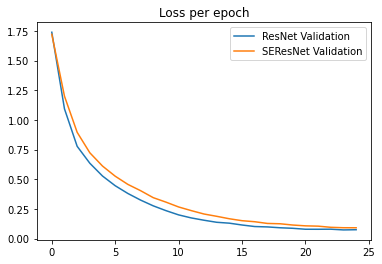

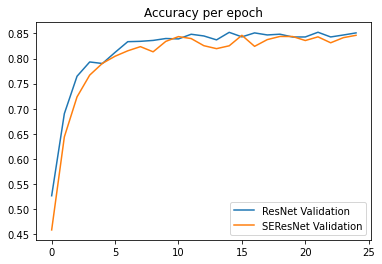

In [43]:
plot_data(val_acc_history_resnet18, loss_acc_history_resnet18, val_acc_history_SEresnet18 , loss_acc_history_SEresnet18)

## Chihuahua Muffin

In this section of Lab03, taken the trained SE_ResNet model from the previous section, the model was fine-tuned by adjusting the hyper-paremeters during the 8-fold cross validation.

Since SE_ResNet was initially trained for a 10-class classification problem, The last layer of the output must be modified. In our case, the last layer was changed from 10 to 2.

The 8 variations (8-fold cross validation) were impleneted with Adam optimizer and crossentropy loss functions and they are as follows:

* criterion = nn.CrossEntropyLoss()
* optimizer = optim.Adam() which starts lr = 0.05 and increases by 0.05 every model.

The model was trained for 25 epochs with the batch size of 4 and their performace at the 25th epoch are:

* With optimizer0: Avg acc = 0.7999999999999999
* With optimizer1: Avg acc = 0.8474999999999999
* With optimizer2: Avg acc = 0.8925
* With optimizer3: Avg acc = 0.8625
* With optimizer4: Avg acc = 0.7300000000000001
* With optimizer5: Avg acc = 0.7300000000000001
* With optimizer6: Avg acc = 0.715
* With optimizer7: Avg acc = 0.8

** average accuracy of all epochs and folds

As for the evalution, optimizer2 was chosen due to its high accuracy as well as relatively less time taken to train which results in 87.50% on 4 different pictures of chihuahua and muffin taken from the internet

### 1. Import the dataset

In [71]:
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import TensorDataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

#mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

dataset = dset.ImageFolder(root='chihuahua_muffin',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


### 2. Define train function

In [72]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    print('====================== New Run =======================',file=open(f"{weights_name}.txt", "a"))

    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), file=open(f"{weights_name}.txt", "a"))
        print('-' * 10, file=open(f"{weights_name}.txt", "a"))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)

                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), file=open(f"{weights_name}.txt", "a"))
            print(f"Epoch time taken: {elapsed_epoch}", file=open(f"{weights_name}.txt", "a"))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), file=open(f"{weights_name}.txt", "a"))
    print('Best val Acc: {:4f}'.format(best_acc), file=open(f"{weights_name}.txt", "a"))

    return  val_acc_history, loss_acc_history

### 3. Check the availability of GPU

In [73]:
import torch
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:0


### 4. Perform 8-Fold Cross Validation

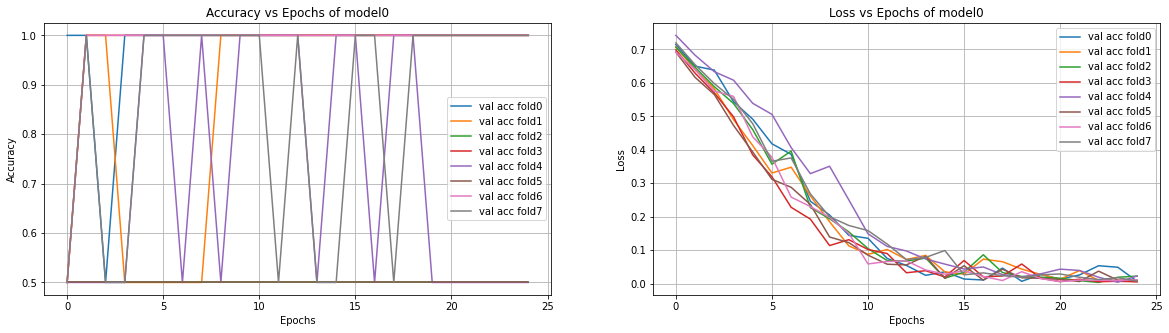

Average accuracy of model0: 0.7999999999999999


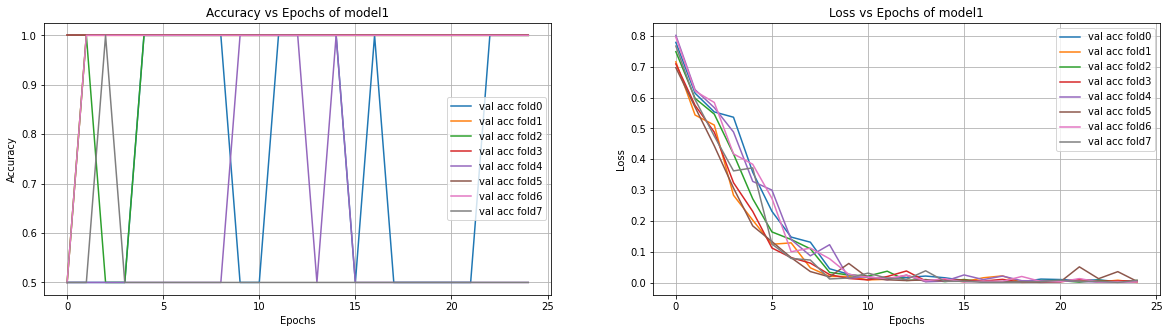

Average accuracy of model1: 0.8474999999999999


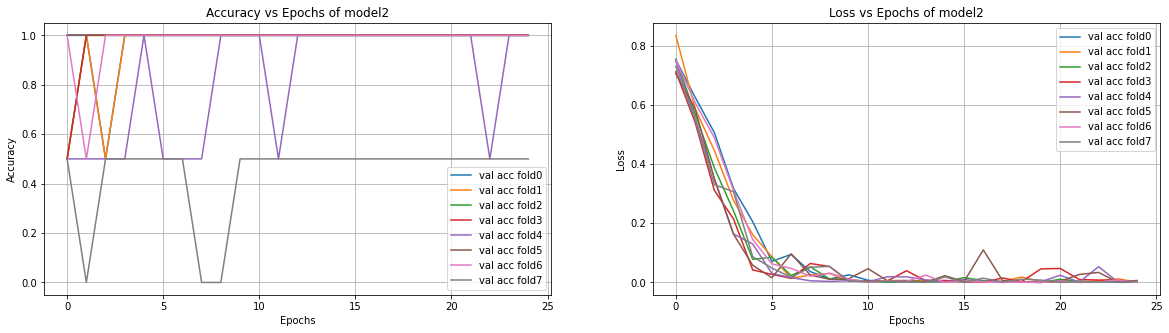

Average accuracy of model2: 0.8925


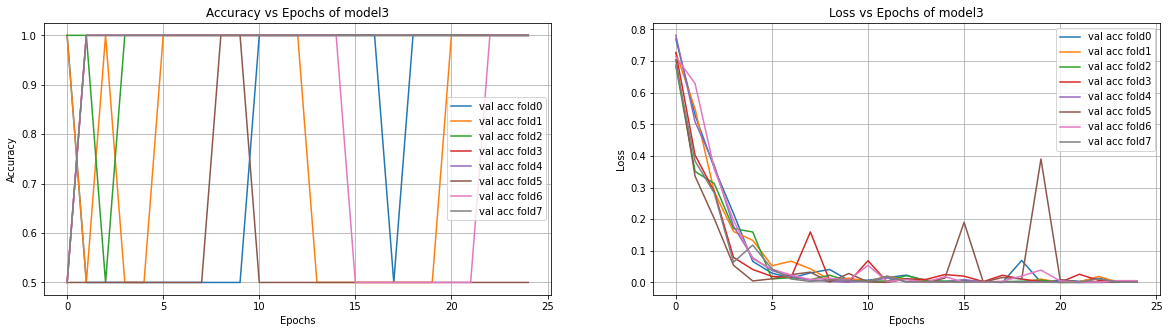

Average accuracy of model3: 0.8625


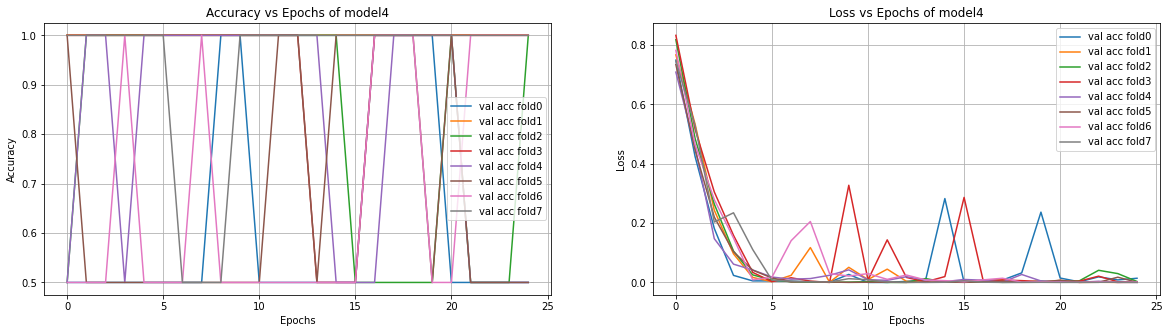

Average accuracy of model4: 0.8125


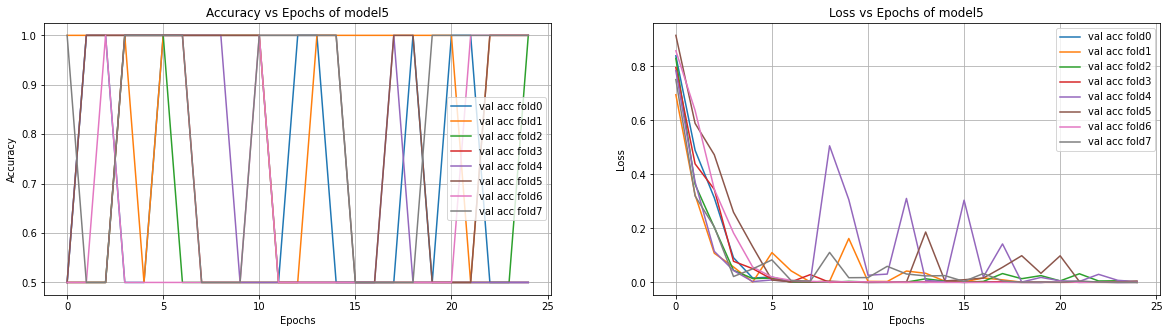

Average accuracy of model5: 0.7300000000000001


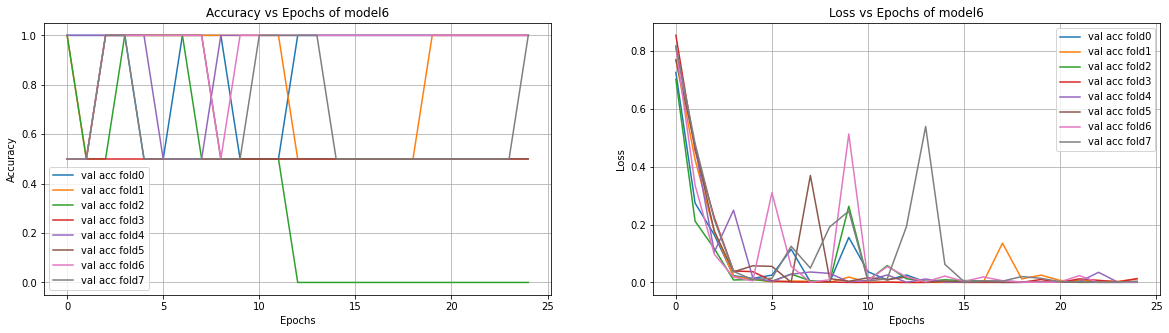

Average accuracy of model6: 0.715


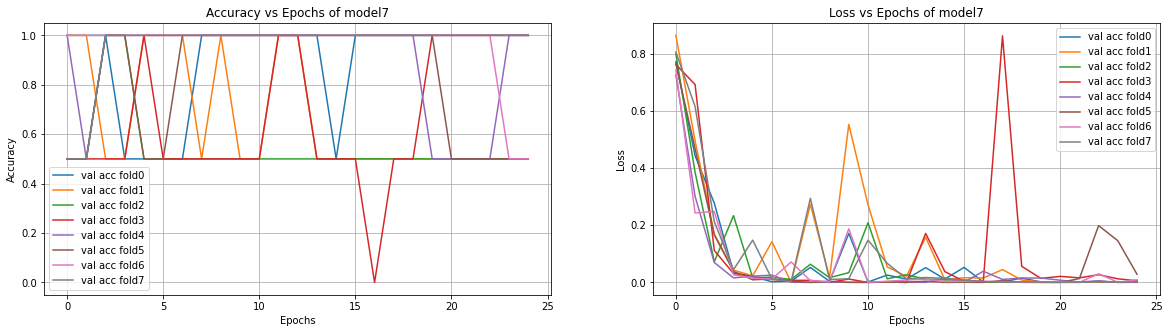

Average accuracy of model7: 0.8


In [74]:
folds = 8
skf = StratifiedKFold(n_splits=folds, shuffle=True)


from modules import ResSENet18
models = []
def make_model(ResSENet18):
    model = ResSENet18()
    model.load_state_dict(torch.load('SEresnet18_bestsofar.pth'))
    model.linear = nn.Linear(512,2)
    model.eval()
    return model

n_models = 8

for i in np.arange(n_models):
    fig,ax = plt.subplots(1,2,sharex=True,figsize=(20,5))
    model_acc = 0
    for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset.targets)):
        print('********************* Fold {}/{} ******************** '.format(fold, 8 - 1), 
              file=open(f"SE_muff_chi_model{i}.txt", "a"))
        batch_size = 4
        train = torch.utils.data.Subset(dataset, train_index)
        val = torch.utils.data.Subset(dataset, val_index)
        
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                                   shuffle=True, num_workers=0, 
                                                   pin_memory=False)
        val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                                 shuffle=True, num_workers=0, 
                                                 pin_memory=False)

        dataloaders = {'train': train_loader, 'val': val_loader}

        model = make_model(ResSENet18)
        model.to(device)
        dataloaders = {'train': train_loader, 'val': val_loader}
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer =  optim.Adam(model.parameters(), lr = 0.005 + 0.005*i)

        val_acc_history, loss_acc_history = train_model(model, dataloaders, 
                                                        criterion, optimizer, 
                                                        25, f'SE_muff_chi_model{i}')

        ax[0].plot(np.arange(25),np.array(val_acc_history),label = f"val acc fold{fold}")
        ax[1].plot(np.arange(25),np.array(loss_acc_history),label = f"val acc fold{fold}")
        ax[0].set_xlabel("Epochs")
        ax[1].set_xlabel("Epochs")
        ax[0].set_ylabel("Accuracy")
        ax[1].set_ylabel("Loss")    
        ax[0].set_title(f"Accuracy vs Epochs of model{i}")
        ax[1].set_title(f"Loss vs Epochs of model{i}")
        ax[0].legend()
        ax[1].legend()
        ax[0].grid(True)
        ax[1].grid(True)
        #print(len(val_acc_history))
        #print(sum(val_acc_history))         
        model_acc = model_acc + sum(val_acc_history)/len(val_acc_history)

    plt.show()
    print(f'Average accuracy of model{i}: {model_acc/8}')

### 5. Train model with optimizer2

Optimizer2 was chosen due to its highest in average accuracy

Optimizer2 = optim.Adam(model.parameters(), lr = 0.015)

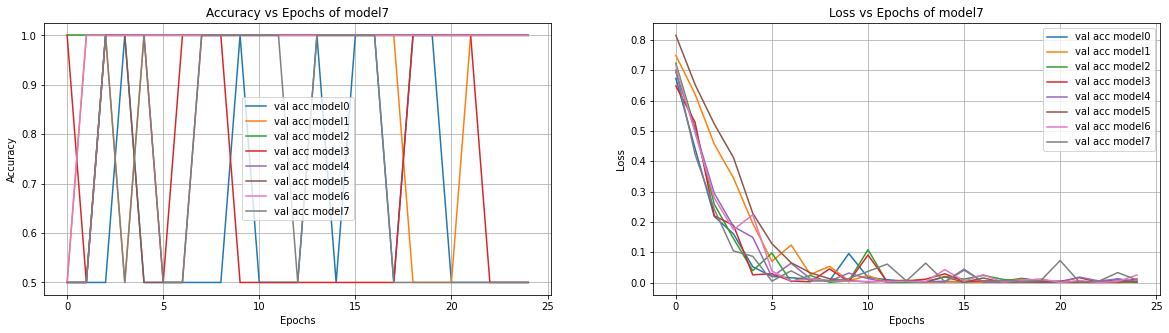

Average accuracy of model7: 0.8524999999999999


In [77]:
fig,ax = plt.subplots(1,2,sharex=True,figsize=(20,5))
model_acc = 0
for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset.targets)):
        print('********************* Fold {}/{} ******************** '.format(fold, 8 - 1), 
              file=open(f"Train_SE_muff_chi_model.txt", "a"))
        batch_size = 4
        train = torch.utils.data.Subset(dataset, train_index)
        val = torch.utils.data.Subset(dataset, val_index)
        
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                                   shuffle=True, num_workers=0, 
                                                   pin_memory=False)
        val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                                 shuffle=True, num_workers=0, 
                                                 pin_memory=False)

        dataloaders = {'train': train_loader, 'val': val_loader}

        model = make_model(ResSENet18)
        model.to(device)
        dataloaders = {'train': train_loader, 'val': val_loader}
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer =  optim.Adam(model.parameters(), lr = 0.005 + 0.005*2)

        val_acc_history, loss_acc_history = train_model(model, dataloaders, 
                                                        criterion, optimizer, 
                                                        25, f'Train_SE_muff_chi_model')

        ax[0].plot(np.arange(25),np.array(val_acc_history),label = f"val acc model{fold}")
        ax[1].plot(np.arange(25),np.array(loss_acc_history),label = f"val acc model{fold}")
        ax[0].set_xlabel("Epochs")
        ax[1].set_xlabel("Epochs")
        ax[0].set_ylabel("Accuracy")
        ax[1].set_ylabel("Loss")    
        ax[0].set_title(f"Accuracy vs Epochs of model{fold}")
        ax[1].set_title(f"Loss vs Epochs of model{fold}")
        ax[0].legend()
        ax[1].legend()
        ax[0].grid(True)
        ax[1].grid(True)
        #print(len(val_acc_history))
        #print(sum(val_acc_history))         
        model_acc = model_acc + sum(val_acc_history)/len(val_acc_history)
plt.show()
print(f'Average accuracy of model{i}: {model_acc/8}')


### 6. Results

In [78]:
results_resnet18_muff = open("Train_SE_muff_chi_model.txt", "r")
print(results_resnet18_muff.read())


====================== Train_SE_muff_chi_model =======================
Epoch 0/24
----------
train Loss: 0.7008 Acc: 0.6429
Epoch time taken: 0.09666061401367188
val Loss: 0.6711 Acc: 0.5000
Epoch time taken: 0.10734295845031738
Epoch 1/24
----------
train Loss: 0.4225 Acc: 1.0000
Epoch time taken: 0.13723373413085938
val Loss: 0.6484 Acc: 0.5000
Epoch time taken: 0.1564638614654541
Epoch 2/24
----------
train Loss: 0.2417 Acc: 1.0000
Epoch time taken: 0.11687064170837402
val Loss: 0.6080 Acc: 1.0000
Epoch time taken: 0.12678956985473633
Epoch 3/24
----------
train Loss: 0.1039 Acc: 1.0000
Epoch time taken: 0.15042591094970703
val Loss: 0.5566 Acc: 0.5000
Epoch time taken: 0.17507648468017578
Epoch 4/24
----------
train Loss: 0.0865 Acc: 1.0000
Epoch time taken: 0.160980224609375
val Loss: 0.5449 Acc: 1.0000
Epoch time taken: 0.2153942584991455
Epoch 5/24
----------
train Loss: 0.0046 Acc: 1.0000
Epoch time taken: 0.18247509002685547
val Loss: 0.5445 Acc: 0.5000
Epoch time taken: 0.19

### 7. Evaluation

#### 7.1 Import the dataset

In [79]:
dataset_test = dset.ImageFolder(root='chi_muff_test',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(dataset_test,batch_size = 8,shuffle = True)

#### 7.2 Define and run the model

In [80]:
model_test = ResSENet18()
model_test.linear = nn.Linear(512,2)
model_test.eval()
model_test.to(device)
model_test.load_state_dict(torch.load(f'Train_SE_muff_chi_model.pth'))
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_pred_label, test_true_label  = evaluate(model_test, test_dataloader, criterion)

In [81]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.485 | Test Acc: 87.50%
